# HackMed 21: Connecting Rhea to UniProt 
Start: 25.04.2021 | author: Camillo Moschner (cm967)

Source Data: ftp://ftp.expasy.org/databases/rhea/ctfiles/rhea-rxn.tar.gz

## Import statements

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
import re
from itertools import combinations
import os 
from glob import glob

In [2]:
from tqdm.notebook import tqdm
from rdkit.Chem import rdChemReactions as rdReact

## Function defintions

In [3]:
def getRheaID(str_element):
    nameID = re.compile(r'\d\d (.*)\nRHEA')
    mo = nameID.search(str_element)
    unprocessed_output_str =mo.group(1)
    return int(unprocessed_output_str)

def getChEBIs(str_element):
    nameID = re.compile(r'[\n$MOL\nCHEBI:]\d\d\d+')
    unprocessed_ChEBI_list = nameID.findall(str_element)
    #print(unprocessed_ChEBI_list)
    ChEBI_list = []
    for item in unprocessed_ChEBI_list:
        if item[0] == ':':
            split_item = item.split(':')[1]
        elif item[0] == '\n':
            split_item = item.split('\n')[1]
        ChEBI_list.append(int(split_item))
    return ChEBI_list

## Rhea Explorer

Load and visualise rxn network using rdkit|:

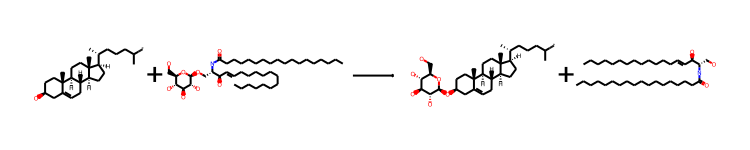

In [4]:
reaction1 = rdReact.ReactionFromRxnFile('/Users/camillomoschner/Desktop/21_HackMed/rxn/58301.rxn')
reaction1

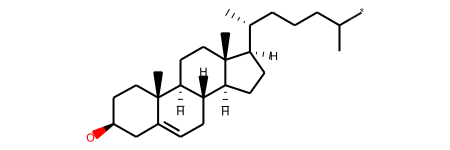

In [5]:
reactant1 = list(reaction1.GetReactants())[0]
reactant1

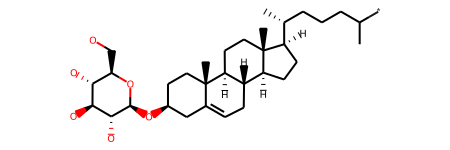

In [6]:
product1 = list(reaction1.GetProducts())[0]
product1

Explore data structure:

In [7]:
f = open("/Users/camillomoschner/Desktop/21_HackMed/rxn/10001.rxn", "r")

extracted_data_list = str(f.read())#.split('$')
extracted_data_list


'$RXN\n\nRhea  rhea-util012520211633  10001\nRHEA:release=118\n  2  2\n$MOL\nCHEBI:15377\n  Marvin  01211112152D          \n\n  3  2  0  0  0  0            999 V2000\n   -0.4125    0.7145    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4125   -0.7145    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n  2  1  1  0  0  0  0\n  2  3  1  0  0  0  0\nM  END\n$MOL\nCHEBI:16459\n  Mrv0541 06041415542D          \n\n  7  6  0  0  0  0            999 V2000\n    0.3572   -0.2062    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.3572    0.2062    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0717   -0.2063    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.7862    0.2062    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0717    0.2063    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0717    1.0313    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7862   -0.2063    0.0000 N   0  0  0  

## rxn Parser

Define directory to all rxn files:

In [8]:
rxn_folder_directory = '/Users/camillomoschner/Desktop/21_HackMed/rxn/'

Load all rxn files into a list:

In [9]:
rxn_folder_directory = glob(rxn_folder_directory+"*.rxn")
rxn_folder_directory.sort()

Loop through rxn files, extracting Rhea ID and all associated ChEBIs for each rxn file:

In [10]:
rhea_ids = []
rhea_ChEBIs  = []
for rxn_file in rxn_folder_directory:
    #print(rxn_file)
    opened_rxn_file = str(open(rxn_file, "r").read())
    
    fresh_rhea_id = getRheaID(opened_rxn_file)
    rhea_ids.append(fresh_rhea_id)
    
    fresh_rhea_ChEBIs = getChEBIs(opened_rxn_file)
    rhea_ChEBIs.append(fresh_rhea_ChEBIs)

Store Rhea IDs and their associated CheBIs inside a Pandas DataFrame:

In [11]:
rhea_df = pd.DataFrame(list(zip(rhea_ids,rhea_ChEBIs)),columns=['rhea_ids','rhea_ChEBIs'])
rhea_df

,rhea_ids,rhea_ChEBIs
0,10001,"[15377, 16459, 28938, 31011]"
1,10002,"[28938, 31011, 15377, 16459]"
2,10005,"[17484, 16017]"
3,10006,"[16017, 17484]"
4,10009,"[29950, 29950, 35924, 50058, 30879, 15377]"
...,...,...
27077,66610,"[167197, 15378, 83062, 167198, 15377]"
27078,66621,"[71550, 15379, 15379, 15379, 57618, 57618, 576..."
27079,66622,"[71542, 15378, 15378, 15378, 15378, 15377, 153..."
27080,66625,"[16175, 15379, 15379, 15379, 57618, 57618, 576..."


## Data Backup

In [12]:
pickle.dump( rhea_df, open( "/Users/camillomoschner/Documents/GitHub/react2drug/rhea_to_ChEBIs.p", "wb" ) )